# PFHub BM 1a in FiPy with Steppyngstounes

This notebook implements [PFHub] Benchmark [1a][spinodal] using [FiPy] and [steppyngstounes].
It also explores alternative initial conditions that are more-periodic than the specification.
The variants are as follows.

## original

This is the initial condition as specified in BM 1a v1.0;
it is not periodic at all.

$$
c_0 = 0.5 + \varepsilon \left\{
                \cos(0.105 \cdot x) \cos(0.110 \cdot y) \\
        + \left[\cos(0.130 \cdot x) \cos(0.087 \cdot y)\right]^2 \\
             +  \cos(0.025 \cdot x  - 0.150 \cdot y)
                \cos(0.070 \cdot x  - 0.020 \cdot y)
    \right\}
$$

## periodic

Using even integer coefficients, this initial condition is exactly periodic at the boundary.

$$
c_0 = 0.5 + \varepsilon \left\{
           \cos\left(\frac{6\pi}{L_\mathrm{x}} x\right) 
           \cos\left(\frac{8\pi}{L_\mathrm{y}} y\right) \\
        + \left[
             \cos\left(\frac{8\pi}{L_\mathrm{x}} x\right) 
             \cos\left(\frac{6\pi}{L_\mathrm{y}} y\right)
           \right]^2 \\
        +  \cos\left(
               \frac{2\pi}{L_\mathrm{x}} x
             - \frac{10\pi}{L_\mathrm{y}} y\right)
           \cos\left(
               \frac{4\pi}{L_\mathrm{x}} x
             - \frac{2\pi}{L_\mathrm{y}} y\right)
    \right\}
$$

The clearly repeating features, especially down the center,
are highly uncharacteristic of real microstructures.

## hybrid

By interpolating coefficients, we should be able to create a periodic halo around the non-periodic initial condition.
This complicates the initialization function, since the coefficients become $x$- and $y$-dependent:

$$
c_0 = 0.5 + \varepsilon \left\{
           \cos\left(A_1^{x,y} \cdot x\right) 
           \cos\left(B_1^{x,y} \cdot y\right)
        + \left[
             \cos\left(A_2^{x,y} \cdot x\right) 
             \cos\left(B_2^{x,y} \cdot y\right)
           \right]^2
        +  \cos\left(
               A_3^{x,y} \cdot x
             - B_3^{x,y} \cdot y\right)
           \cos\left(
               A_4^{x,y} \cdot x
             - B_4^{x,y} \cdot y\right)
    \right\}
$$

<!-- links -->
[FiPy]: https://www.ctcms.nist.gov/fipy
[spinodal]: https://pages.nist.gov/pfhub/benchmarks/benchmark1.ipynb/#(a)-Square-periodic
[steppyngstounes]: https://github.com/usnistgov/steppyngstounes
[PFHub]: https://pages.nist.gov/pfhub/

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

In [2]:
L = 200.
dx = 0.2
w = 3.

N = np.rint(L / dx).astype(int)
x = np.linspace(0., L, N)
X, Y = np.meshgrid(x, x, indexing="xy")

c0 = 0.5
ϵ = 0.01

# complementary tanh function (cf. erfc)
tanhc = lambda x: (1 - np.tanh((x - L + w) / np.sqrt(2))) / 2

# y = y0 + (y1 - y0) / (x1 - x0) * (x - x0)
lerp = lambda x, y0, y1: y0 + (y1 - y0) / w * (x - (L - w))

# phase-field interpolation function
h_phi = lambda x: x**3 * (6 * x**2 - 15 * x + 10)

ic = lambda x, y, A, B: c0 + ϵ * (np.cos(A[0] * x) * np.cos(B[0] * y) \
                               + (np.cos(A[1] * x) * np.cos(B[1] * y))**2 \
                               +  np.cos(A[2] * x  -     B[2] * y) \
                               *  np.cos(A[3] * x  -     B[3] * y))

A0 = np.pi/L * np.array([6.6845076, 8.2760570, 1.5915494, 4.4563384])  # [0.105, 0.130, 0.025, 0.070]
B0 = np.pi/L * np.array([7.0028175, 5.5385920, 9.5492966, 1.2732395])  # [0.110, 0.087, 0.150, 0.020]

Ap = np.pi/L * np.array([6., 8.0, 2.0, 4.0])
Bp = np.pi/L * np.array([6., 6.0, 10., 2.0])

orig_ic = ic(X, Y, A0, B0)
peri_ic = ic(X, Y, Ap, Bp)

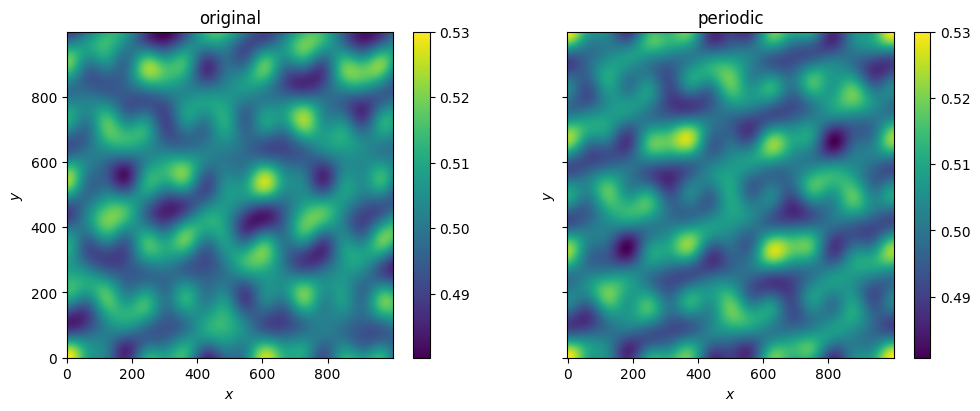

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True, constrained_layout=True)

fig.colorbar(axs[0].imshow(orig_ic, interpolation=None, origin="lower"));
axs[0].set_title("original");
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$y$");

fig.colorbar(axs[1].imshow(peri_ic, interpolation=None, origin="lower"));
axs[1].set_title("periodic");
axs[1].set_xlabel("$x$");
axs[1].set_ylabel("$y$");

## Try a $\tanh$ interpolation *(this is not the one)*

In [4]:
# use the numpy broadcast semantics to interpolate coefficients
At = A0[:,None,None] * tanhc(X) + Ap[:,None,None] * (1 - tanhc(X))
Bt = B0[:,None,None] * tanhc(Y) + Bp[:,None,None] * (1 - tanhc(Y))

Z_orig = ic(X, Y, A0, B0)
Z_test = ic(X, Y, At, Bt)

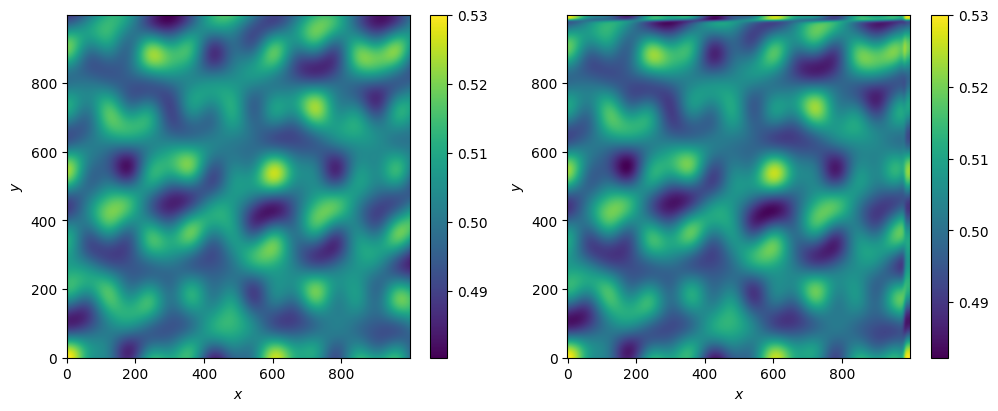

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False, constrained_layout=True)

fig.colorbar(axs[0].imshow(Z_orig, interpolation=None, origin="lower"));
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$y$");

fig.colorbar(axs[1].imshow(Z_test, interpolation=None, origin="lower"));
axs[1].set_xlabel("$x$");
axs[1].set_ylabel("$y$");

## Use a $\sin$ interpolation *(it works!)*

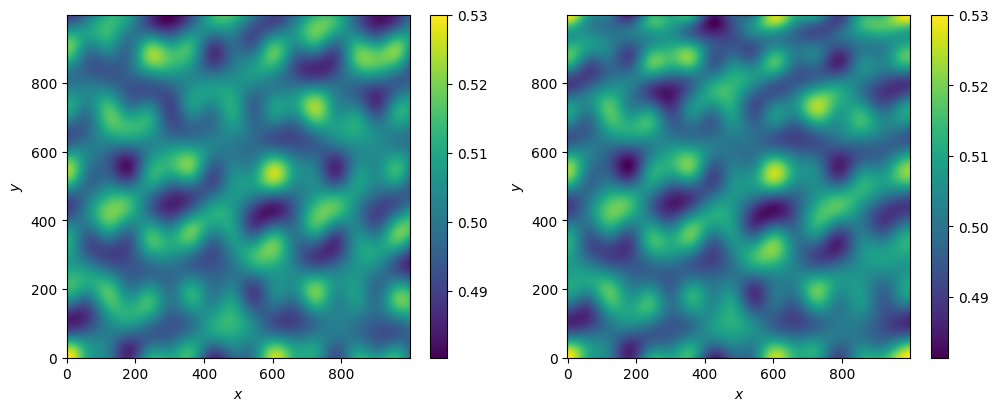

In [6]:
sic = lambda x: np.power(np.sin(np.pi * x / L), 2/3)

# use the numpy broadcast semantics to interpolate coefficients
mapX = sic(X)
mapY = sic(Y)

Ac = A0[:,None,None] * mapX + Ap[:,None,None] * (1 - mapX)
Bc = B0[:,None,None] * mapY + Bp[:,None,None] * (1 - mapY)

Z_orig = ic(X, Y, A0, B0)
Z_test = ic(X, Y, Ac, Bc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False, constrained_layout=True)

fig.colorbar(axs[0].imshow(Z_orig, interpolation=None, origin="lower"));
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$y$");

fig.colorbar(axs[1].imshow(Z_test, interpolation=None, origin="lower"));
axs[1].set_xlabel("$x$");
axs[1].set_ylabel("$y$");

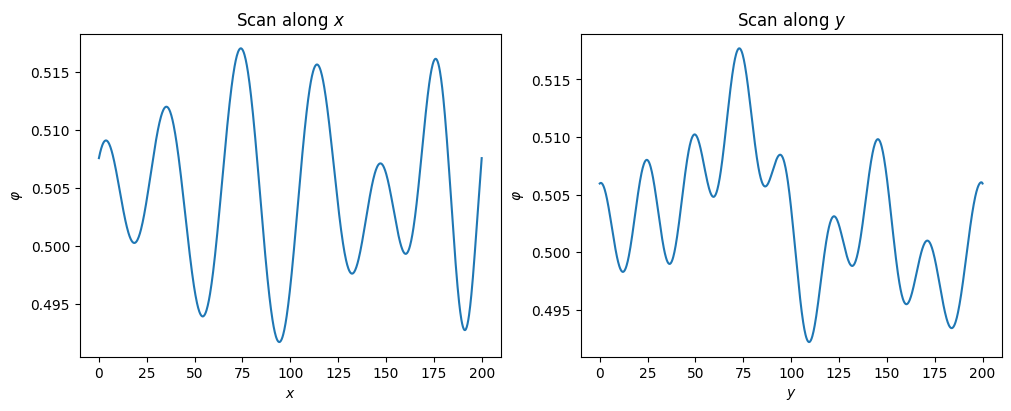

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False, constrained_layout=True)

axs[0].plot(x, Z_test[:,3*N//8])
axs[0].set_title("Scan along $x$")
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$\\varphi$");

axs[1].plot(x, Z_test[3*N//8,:])
axs[1].set_title("Scan along $y$")
axs[1].set_xlabel("$y$");
axs[1].set_ylabel("$\\varphi$");

In [8]:
l2x = LA.norm(Z_test[:,0] - Z_test[:,-1])
l2y = LA.norm(Z_test[0,:] - Z_test[-1,:])
print(f"L2-norm along x boundary: {l2x:.4e}")
print(f"L2-norm along x boundary: {l2y:.4e}")

L2-norm along x boundary: 7.5241e-12
L2-norm along x boundary: 1.0245e-11
